In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import xarray as xr

from osgeo import gdal
#from gistool import rasterize
import pyhdf
from pyhdf.SD import SD
import geopandas as gpd

from scipy import stats
from scipy import integrate
from numpy import exp
import math
from pymannkendall import original_test as mk

import matplotlib as mpl
import matplotlib.pyplot as plt
## set the line width of the hatch
mpl.rcParams['hatch.linewidth'] = 0.5
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import matplotlib.ticker as mticker

## pre

In [2]:
def create_date_list(start_year, end_year):
    date_list = []
    year = start_year
    while year <= end_year:
        date1 = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='8D')
        date_list.append(date1)
        year += 1
    date_array = np.concatenate([np.array(date) for date in date_list])
    return date_array

In [7]:
import os
from glob import glob  # Import the glob module
files = glob('/portal1/dell/li-b/yankaiLAI/HiQ_LAI_WGS84_5km_8day_2016-2020/*.tif')
start = 2016
end = 2020
datelist = create_date_list(start, end)

ds_sif = []
for i, f in enumerate(files):
    ds = xr.open_dataset(f)
    ds1 = ds['band_data'].sel(y=slice(34.025,24.475), x=slice(110.475, 122.025), band=2).to_dataset(name='vari')
    t = datelist[i]
    ds2 = xr.Dataset({'vari': (['lat', 'lon'], ds1['vari'].values)},
                        coords={'lat': (['lat'], ds1.y.values),
                                'lon': (['lon'], ds1.x.values)})
    ds2 = ds2.expand_dims(time=[t])
    ds_sif.append(ds2)
    
ds_sif_combined = xr.concat(ds_sif, dim='time')
ds_sif_combined.to_netcdf('/portal1/dell/li-b/yankaiLAI/HiQ_LAI_WGS84_5km_8day_2016-2020_qc.nc')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [3]:
import os
from glob import glob
files = glob('/portal1/dell/li-b/yankaiLAI/*.nc')

ds = []
for i, f in enumerate(files):
    ds0 = xr.open_dataset(f)
    ds.append(ds0)

ds_combined = xr.concat(ds, dim='time')
ds_combined

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.Dataset>
Dimensions:  (time: 1932, lat: 213, lon: 257)
Coordinates:
  * time     (time) datetime64[ns] 2002-01-01 2002-01-09 ... 2022-12-27
  * lat      (lat) float64 34.02 33.98 33.93 33.89 ... 24.64 24.59 24.55 24.5
  * lon      (lon) float64 110.5 110.6 110.6 110.6 ... 121.9 121.9 122.0 122.0
Data variables:
    vari     (time, lat, lon) float64 9.0 7.0 5.0 3.0 ... 255.0 255.0 255.0

In [4]:
import os
from glob import glob
files = glob('/portal1/dell/li-b/yankaiLAI/qc/*.nc')

ds = []
for i, f in enumerate(files):
    ds0 = xr.open_dataset(f)
    ds.append(ds0)

ds_combined_qc = xr.concat(ds, dim='time')
ds_combined_qc

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.Dataset>
Dimensions:  (time: 966, lat: 213, lon: 257)
Coordinates:
  * time     (time) datetime64[ns] 2002-01-01 2002-01-09 ... 2022-12-27
  * lat      (lat) float64 34.02 33.98 33.93 33.89 ... 24.64 24.59 24.55 24.5
  * lon      (lon) float64 110.5 110.6 110.6 110.6 ... 121.9 121.9 122.0 122.0
Data variables:
    vari     (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 157.0 157.0 157.0

In [6]:
times = ds_combined['time'].values
vari = ds_combined['vari'].sel(time=times).to_dataset(name='vari')
qc = ds_combined_qc['vari'].sel(time=times).to_dataset(name='qc')
times1 = vari.time.values
x = vari.dims['lon']
y = vari.dims['lat']

arr_s0 = np.zeros(((1,y,x)))

for t in times1:
    print(t, end='\r')
    qc_a = qc.sel(time=t).qc.values
    
    
    qc_b = np.zeros((y, x), dtype=bool)
    
    #qc_b = (np.bitwise_and(qc_a.astype(np.uint8), 0b11100000) != 128) & (np.bitwise_and(qc_a.astype(np.uint8), 0b00011000) != 8)
    qc_b = np.bitwise_and(qc_a.astype(np.uint8), 0b00011000) != 8

    
    vari_a = vari.sel(time=t).vari.values
    vari_b = np.zeros((y, x))

    # vari_b = np.where(qc_b & (vari_a<3270), vari_a, np.nan)
    vari_b = np.where(qc_b, vari_a, np.nan)  #################### haven't processed the fill value

              
    vari_c = vari_b.reshape(1,y,x)
    
    arr_s0 = np.append(arr_s0,vari_c,axis=0)
    
    
arr_s1 = arr_s0[1:,:,:]

dsvari1 = xr.Dataset({'vari': (['time','lat','lon'], arr_s1)},
                    coords={ 'time': (['time'], vari.time.values),
                            'lat': (['lat'], vari.lat.values),
                            'lon': (['lon'], vari.lon.values),})
dsvari1.to_netcdf('/portal1/dell/li-b/yankaiLAI/qc.nc')

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

## area-mean

In [8]:
## this dataset needs scale factor 0.1#############################
ds0 = xr.open_dataset('/portal1/dell/li-b/yankaiLAI/qc_0.05.nc')

# exclude taiwan(120.5,122)(24.5,25.5)   (100,115)(85,95)
arr = ds0['vari'].values
lats = ds0.lat.values
lons = ds0.lon.values

for i in range(0,len(lats)):
    for j in range(0,len(lons)):
        if i>=169 and j>=200:
            arr[:,i,j] = np.nan
        else:
            continue

ds00 = xr.Dataset({'vari': (['time','lat','lon'], arr*0.1)},
                      coords={'time': (['time'], ds0.time.values), 
                              'lat': (['lat'], ds0.lat.values),
                      'lon': (['lon'], ds0.lon.values),})

ds_fill = ds00['vari'].where(ds00['vari']<=10, np.nan).to_dataset(name='vari')
ds000 = ds_fill['vari'].resample(time='D').pad().to_dataset()
ds0000 = ds000.resample(time='M').mean(skipna=True)
ds1 = ds0000.sel(time=slice('2002-07-31','2022-12-31'))

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [2]:
ds1 = xr.open_dataset('/portal1/dell/li-b/multiregression/lai1.nc')

In [3]:
ds_m0 = ds1.sel(time=ds1['time.month'].isin([7]))
ds_m = ds_m0['vari'].values*0.1 ##########################################scale 0.1

anos = np.zeros_like(ds_m)

for i in range(0,ds_m.shape[2]):
    for j in range(0,ds_m.shape[1]):
        v1 = ds_m[:,j,i]
        date = np.arange(2002,2023)
        
        non_nan_count = np.count_nonzero(~np.isnan(v1))
        if non_nan_count > 1:
            tr = mk(v1, alpha=0.05).trend
            if tr=='increasing':
                pvalue=1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='decreasing':
                pvalue=-1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='no trend':
                pvalue=np.nan
                anos[:,j,i] = v1 - v1.mean()
        else:
            anos[:,j,i] = v1 - v1.mean()
            
ds_ano7 = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                      coords={'time': (['time'], ds_m0.time.values), 
                              'lat': (['lat'], ds_m0.lat.values),
                      'lon': (['lon'], ds_m0.lon.values),})
##################################################################################################
ds_m0 = ds1.sel(time=ds1['time.month'].isin([8]))
ds_m = ds_m0['vari'].values*0.1

anos = np.zeros_like(ds_m)

for i in range(0,ds_m.shape[2]):
    for j in range(0,ds_m.shape[1]):
        v1 = ds_m[:,j,i]
        date = np.arange(2002,2023)
        
        non_nan_count = np.count_nonzero(~np.isnan(v1))
        if non_nan_count > 1:
            tr = mk(v1, alpha=0.05).trend
            if tr=='increasing':
                pvalue=1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='decreasing':
                pvalue=-1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='no trend':
                pvalue=np.nan
                anos[:,j,i] = v1 - v1.mean()
        else:
            anos[:,j,i] = v1 - v1.mean()
            
ds_ano8 = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                      coords={'time': (['time'], ds_m0.time.values), 
                              'lat': (['lat'], ds_m0.lat.values),
                      'lon': (['lon'], ds_m0.lon.values),})
##############################################################################################
ds_m0 = ds1.sel(time=ds1['time.month'].isin([9]))
ds_m = ds_m0['vari'].values*0.1

anos = np.zeros_like(ds_m)

for i in range(0,ds_m.shape[2]):
    for j in range(0,ds_m.shape[1]):
        v1 = ds_m[:,j,i]
        date = np.arange(2002,2023)
        
        non_nan_count = np.count_nonzero(~np.isnan(v1))
        if non_nan_count > 1:
            tr = mk(v1, alpha=0.05).trend
            if tr=='increasing':
                pvalue=1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='decreasing':
                pvalue=-1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='no trend':
                pvalue=np.nan
                anos[:,j,i] = v1 - v1.mean()
        else:
            anos[:,j,i] = v1 - v1.mean()
            
ds_ano9 = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                      coords={'time': (['time'], ds_m0.time.values), 
                              'lat': (['lat'], ds_m0.lat.values),
                      'lon': (['lon'], ds_m0.lon.values),})
########################################################################################################
ds_m0 = ds1.sel(time=ds1['time.month'].isin([7,8,9]))
ds_m1 = ds_m0.groupby('time.year').mean(dim='time',skipna=True)
ds_m = ds_m1['vari'].values*0.1

anos = np.zeros_like(ds_m)

for i in range(0,ds_m.shape[2]):
    for j in range(0,ds_m.shape[1]):
        v1 = ds_m[:,j,i]
        date = np.arange(2002,2023)
        
        non_nan_count = np.count_nonzero(~np.isnan(v1))
        if non_nan_count > 1:
            tr = mk(v1, alpha=0.05).trend
            if tr=='increasing':
                pvalue=1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='decreasing':
                pvalue=-1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='no trend':
                pvalue=np.nan
                anos[:,j,i] = v1 - v1.mean()
        else:
            anos[:,j,i] = v1 - v1.mean()
            
ds_ano789 = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                      coords={'time': (['time'], ds_ano7.time.values),  ## use 07-31 as 789 date
                              'lat': (['lat'], ds_m0.lat.values),
                      'lon': (['lon'], ds_m0.lon.values),})

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [4]:
c7 = ds_ano7['vari'].mean(dim=['lat','lon'],skipna=True).values
c8 = ds_ano8['vari'].mean(dim=['lat','lon'],skipna=True).values
c9 = ds_ano9['vari'].mean(dim=['lat','lon'],skipna=True).values
c789 = ds_ano789['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range('2002','2023',freq='Y')
df1 = pd.DataFrame({'time':times,'jul_ano':c7,'agu_ano':c8,'sep_ano':c9,'jas_ano':c789})
df1

,time,jul_ano,agu_ano,sep_ano,jas_ano
0,2002-12-31,-0.001378,-0.003131,-0.023150,-0.008009
1,2003-12-31,-0.002813,-0.022717,-0.008093,-0.009137
2,2004-12-31,0.019169,-0.028121,-0.015573,-0.006804
3,2005-12-31,0.001449,-0.013146,-0.010320,-0.006591
4,2006-12-31,-0.015407,0.013730,0.005742,0.002127
5,2007-12-31,-0.000840,0.007111,0.004957,0.004207
6,2008-12-31,-0.006946,0.002214,0.003433,-0.000140
7,2009-12-31,-0.014188,0.004687,0.004235,-0.001364
8,2010-12-31,-0.013652,0.010401,0.014737,0.003597
9,2011-12-31,-0.004222,0.009103,0.000979,0.001795


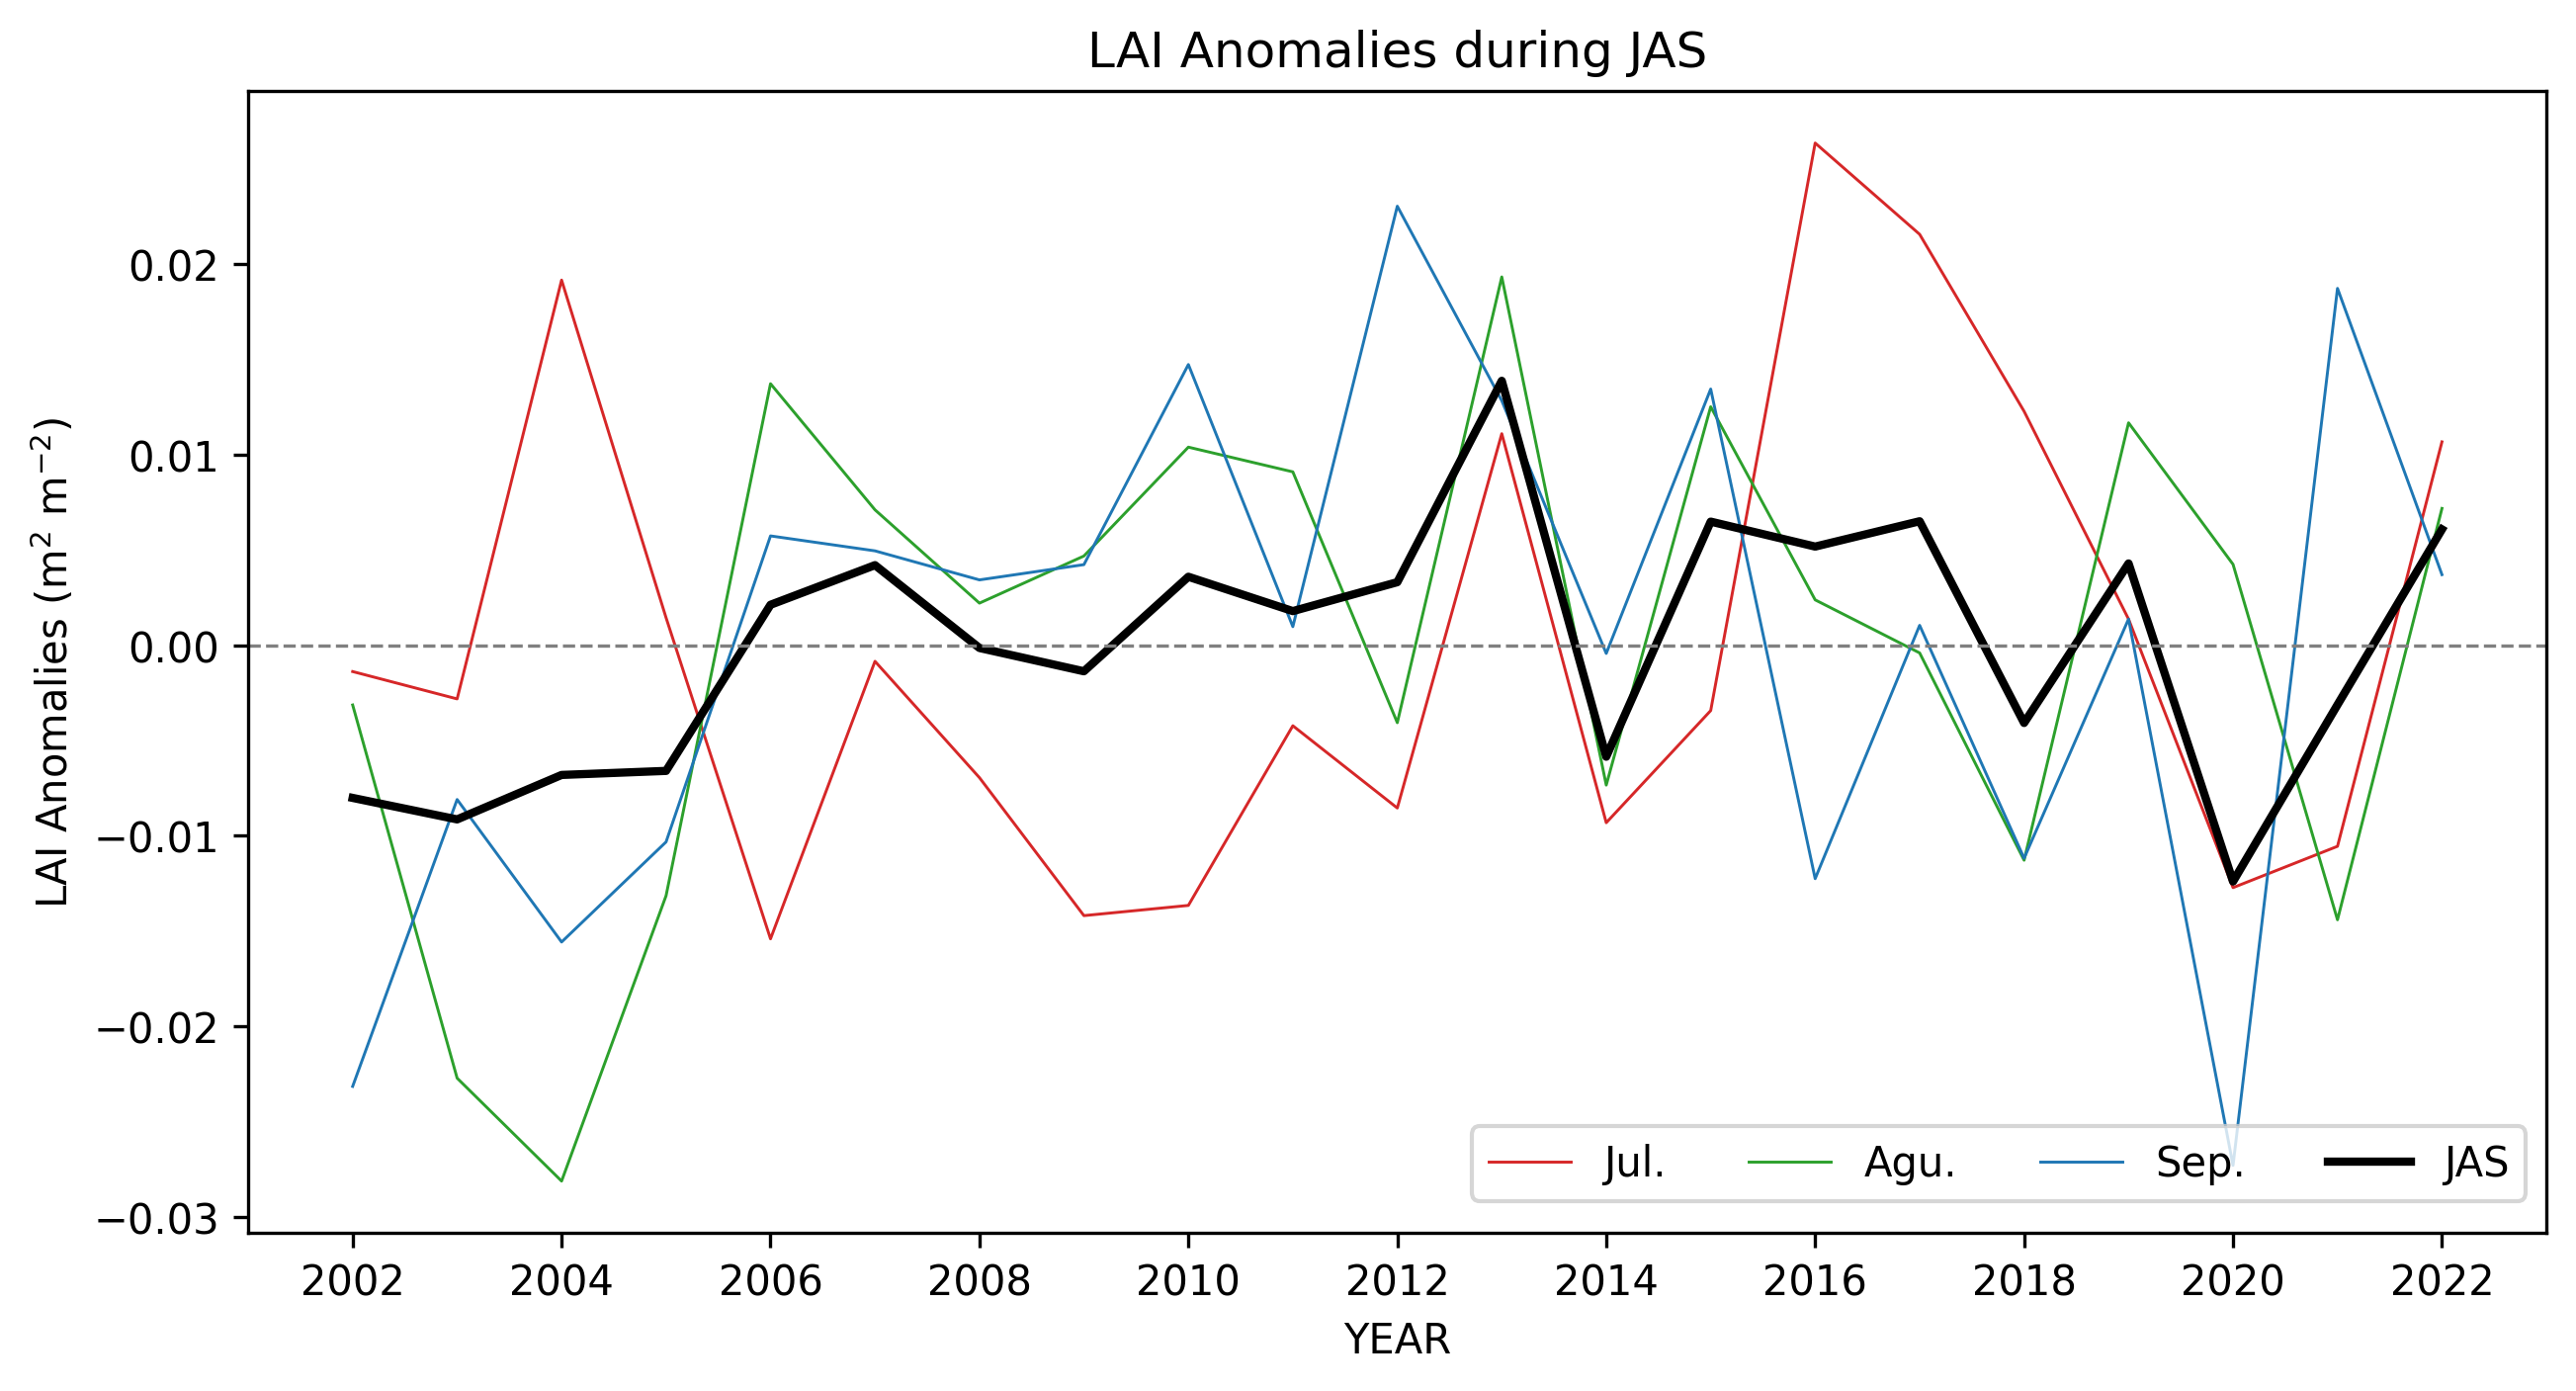

In [8]:
date = np.arange(2002,2023)
v1 = df1['jul_ano']
v2 = df1['agu_ano']
v3 = df1['sep_ano']
v4 = df1['jas_ano']

fig, ax = plt.subplots(1,1,dpi=300,figsize=(10,5))


ax.plot(date, v1,color='tab:red',lw=0.7, ls='-', label='Jul.')
ax.plot(date, v2,color='tab:green',lw=0.7, ls='-', label='Agu.')
ax.plot(date, v3,color='tab:blue',lw=0.7, ls='-', label='Sep.')
ax.plot(date, v4,color='black',lw=2, ls='-', label='JAS')

ax.set_ylabel('LAI Anomalies (m$^2$ m$^{-2}$)')
#ax1.set_ylabel('PRR (%)')
ax.set_xlabel('YEAR')
custom_ticks = np.arange(2002, 2023, step=2)  # Define the tick locations
custom_tick_labels = [str(year) for year in custom_ticks]  # Define the tick labels

ax.set_xticks(custom_ticks)
ax.set_xticklabels(custom_tick_labels)

ax.axhline(y=0, color='gray', linestyle='--',lw=0.8)
    
#figname = filename.replace('.txt','')
ax.set_title('LAI Anomalies during JAS')
ax.set_xlim(date[0]-1, date[-1]+1)
fig.legend(loc="lower right", bbox_to_anchor=(1, 0.01), bbox_transform=ax.transAxes, ncol = 5)

#plt.savefig('D:/rice/figs/middleyield.png')                         
plt.show()

In [27]:
ds_ano789.to_netcdf('/portal1/dell/li-b/multiregression/lai.nc')

## veg. type

In [5]:
### 0-Water, 1-Evergreen Needleleaf, 2-Evergreen Broadleaf, 3-Deciduous Needleleaf, 4-Deciduous Broadleaf, 5-Mixed Forests, 
# 6-Closed Shrublands, 7-Open Shrublands, 8-Woody Savannas, 9-Savannas, 10-Grasslands, 11-Permanent Wetlands, 
# 12-Croplands, 13-Urban, 14-Cropland/Natural Mosaics, 15-Permanent Snow and Ice, 16-Barren

mask = xr.open_dataset('/portal1/dell/li-b/LC_IGBP_2022_epsg4326.tif')
aa = mask['band_data'][0,:,:].values
data = {'Category': aa[~np.isnan(aa)].ravel()}
df = pd.DataFrame(data)

value_counts = df['Category'].value_counts()
value_counts
# 12-crop 14-mosaics;  1- 2-evergreen broadleaf 4-deciduous broadleaf 5-mixed forest 8-woody savannas 9-savannas

Category
12.0    9646
8.0     8999
9.0     7893
0.0     5543
2.0     4178
14.0    2414
5.0     2210
13.0    1728
4.0      897
11.0     186
1.0      163
10.0      31
16.0       2
Name: count, dtype: int64

In [6]:
x = ds_ano789.dims['lon']
y = ds_ano789.dims['lat']
qc_a = mask['band_data'].sel(band=1).values
qc_b = np.zeros((y, x), dtype=bool)
qc_b = (qc_a==1) | (qc_a == 2) | (qc_a == 4) | (qc_a == 5)
vari_a = ds_ano789['vari'][20,:,:].values
vari_b = np.zeros((y, x))
vari_b = np.where(qc_b, vari_a, np.nan)
array_1b = vari_b.ravel()
pv = stats.ttest_ind(array_1b[~np.isnan(array_1b)],0).pvalue
print('forest', np.nanmean(vari_b), pv)
ds_tree = xr.Dataset({'vari': (['lat','lon'], vari_b)},
                    coords={ 
                            'lat': (['lat'], ds_ano789.lat.values),
                            'lon': (['lon'], ds_ano789.lon.values),})

x = ds_ano789.dims['lon']
y = ds_ano789.dims['lat']
qc_a = mask['band_data'].sel(band=1).values
qc_b = np.zeros((y, x), dtype=bool)
qc_b = (qc_a == 8) | (qc_a == 9)
vari_a = ds_ano789['vari'][20,:,:].values
vari_b = np.zeros((y, x))
vari_b = np.where(qc_b, vari_a, np.nan)
pv = stats.ttest_ind(array_1b[~np.isnan(array_1b)],0).pvalue
print('savanna', np.nanmean(vari_b), pv)
ds_sava = xr.Dataset({'vari': (['lat','lon'], vari_b)},
                    coords={ 
                            'lat': (['lat'], ds_ano789.lat.values),
                            'lon': (['lon'], ds_ano789.lon.values),})


x = ds_ano789.dims['lon']
y = ds_ano789.dims['lat']
qc_a = mask['band_data'].sel(band=1).values
qc_b = np.zeros((y, x), dtype=bool)
qc_b = (qc_a == 12) | (qc_a == 14)
vari_a = ds_ano789['vari'][20,:,:].values
vari_b = np.zeros((y, x))
vari_b = np.where(qc_b, vari_a, np.nan)
pv = stats.ttest_ind(array_1b[~np.isnan(array_1b)],0).pvalue
print('crop', np.nanmean(vari_b), pv)
ds_crop = xr.Dataset({'vari': (['lat','lon'], vari_b)},
                    coords={ 
                            'lat': (['lat'], ds_ano789.lat.values),
                            'lon': (['lon'], ds_ano789.lon.values),})

forest 0.26507305906816164 0.4194776941532157
savanna 0.006847847056895048 0.4194776941532157
crop 0.023795608831390702 0.4194776941532157


In [7]:
def exclude_sichuan(ds_full):
    arr = ds_full['vari'].values.copy()
    arr[:80,:51] = np.nan
    ds_ex = xr.Dataset({'vari': (['lat','lon'], arr)},
                      coords={ 
                                'lat': (['lat'], ds_full.lat.values),
                        'lon': (['lon'], ds_full.lon.values),})
    return ds_ex

In [8]:
ds_tree1 = exclude_sichuan(ds_tree)
ds_crop1 = exclude_sichuan(ds_crop)

In [9]:
import pyhdf
from pyhdf.SD import SD, SDC  

f = SD('/portal1/dell/li-b/MCD12C1.A2022001.061.2023244164746.hdf', SDC.READ)
# f.datasets()
newlat = np.linspace(89.975, -89.975, 3600) ## care about the order of lat and lon
newlon = np.linspace(-179.975, 179.975, 7200)

varis = f.select('Land_Cover_Type_1_Percent')[:,:,1]
ds_per1 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,2]
ds_per2 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,4]
ds_per4 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,5]
ds_per5 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,12]
ds_per12 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,14]
ds_per14 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

arrl1 = ds_per1['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl2 = ds_per2['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl4 = ds_per4['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl5 = ds_per5['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl12 = ds_per12['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl14 = ds_per14['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values

arr_p = arrl1 + arrl2 + arrl4 + arrl5
arr_p1 = arrl12 + arrl14

In [10]:
dem = xr.open_dataset('/portal1/dell/li-b/dem0.05.nc')
dems = dem['vari'].sel(time='2022-12-31').values

In [22]:
from scipy.stats import mode

x_1d_data = arr_p.ravel()
y_1d_data = dems.ravel()
vari_b = ds_tree1['vari'].values
z_1d_data = vari_b.ravel()

x_1d = arr_p[~np.isnan(arr_p)].ravel()
y_1d = dems[~np.isnan(dems)].ravel()
z_1d = vari_b[~np.isnan(vari_b)].ravel()

bins = 100
x = np.linspace(np.round(x_1d.min(), decimals=1), np.round(x_1d.max(), decimals=1), bins)
y = np.linspace(np.round(y_1d.min(), decimals=1), np.round(y_1d.max(), decimals=1), bins)
x_gap = (x.max()-x.min())/bins
y_gap = (y.max()-y.min())/bins
out_2d_arr = xr.DataArray(np.zeros((bins,bins)), [('dem',y),('veg',x)])

for i in range(bins):
    for j in range(bins):
        index = np.argwhere(
            (x_1d_data >= x[j]-x_gap/2) & (x_1d_data < x[j]+x_gap/2) & (y_1d_data >= y[i]-y_gap/2) & (y_1d_data < y[i]+y_gap/2)
        ).ravel()
        sel = z_1d_data[index]
        if len(sel) == 0:
            out_2d_arr[i][j] = np.nan
        else:
            results = mode(sel)
            out_2d_arr[i][j] = results.mode

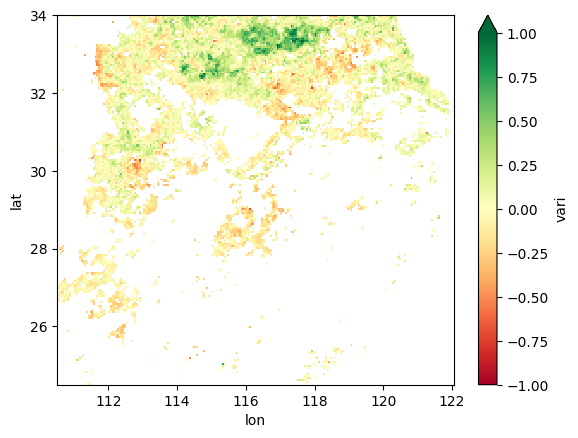

In [26]:
ds_crop['vari'].plot(vmax=1,vmin=-1,cmap='RdYlGn')

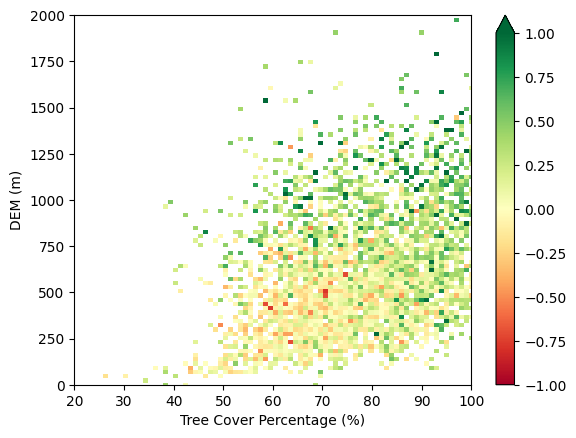

In [25]:
plot = out_2d_arr.plot(vmax=1, vmin=-1, cmap='RdYlGn')
ax = plot.axes

ax.set_xlim(20, 100)
ax.set_ylim(0,2000)
ax.set_xlabel('Tree Cover Percentage (%)')
ax.set_ylabel('DEM (m)')
plt.show()

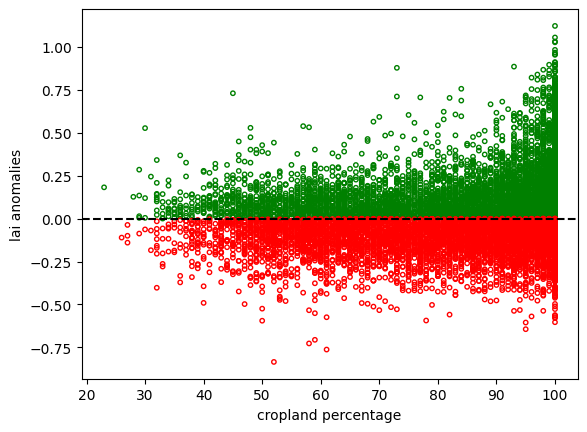

In [35]:
plt.scatter(x_1d_data[z_1d_data >= 0], z_1d_data[z_1d_data >= 0], s=10, facecolors='none', edgecolors='green')
plt.scatter(x_1d_data[z_1d_data < 0], z_1d_data[z_1d_data < 0], s=10, facecolors='none', edgecolors='red')
plt.xlabel('cropland percentage')
plt.ylabel('lai anomalies')
plt.axhline(y=0, color='black', linestyle='--')

# from scipy.optimize import curve_fit
# def func(x, a, b, c):
#     return a * x**2 + b * x + c
# popt, pcov = curve_fit(func, x_1d_data, z_1d_data, nan_policy='omit')
# plt.plot(x_1d_data, func(x_1d_data, *popt), color='firebrick', linestyle='-')
# print(popt)

In [89]:
from scipy.optimize import fsolve

# Define the function representing the fitted curve
def fitted_curve(x):
    return func(x, *popt)

# Define a function to find the intersection point with y=0
def find_intersection():
    # Use fsolve to find the root of the equation f(x) = 0
    x_intersection = fsolve(fitted_curve, 0)
    return x_intersection[0]

# Find the x-coordinate of the intersection point
x_intersection = find_intersection()
print("Intersection point (x-coordinate):", x_intersection)

Intersection point (x-coordinate): 54.88882806367157


## spatial plot

In [17]:
d7_0 = ds_ano7['vari'].sel(time='2022-07-31').values
box7 = d7_0[~np.isnan(d7_0)].ravel()

d8_0 = ds_ano8['vari'].sel(time='2022-08-31').values
box8 = d8_0[~np.isnan(d8_0)].ravel()

d9_0 = ds_ano9['vari'].sel(time='2022-09-30').values
box9 = d9_0[~np.isnan(d9_0)].ravel()

d789_0 = ds_ano789['vari'].sel(time='2022-07-31').values
box789 = d789_0[~np.isnan(d789_0)].ravel()

box = [box7,box8,box9,box789]
for i in box:
    lo = np.nanpercentile(i,q=25)
    up = np.nanpercentile(i,q=75)
    upbo = up+1.5*(up-lo)
    lobo = lo-1.5*(up-lo)
    maxmum = i.max()
    minmum = i.min()
    print(upbo, lobo, maxmum, minmum)

0.8135567997236329 -0.6200594847859824 1.9692197892923176 -1.9245032034056357
0.7347065199760483 -0.6285201048553121 1.704516170605932 -2.0758252173492213
0.7344895961587217 -0.7083652396515783 1.9724123358773236 -1.5705781055313421
0.5972088651398435 -0.521563506225637 1.7416778924623797 -1.0679697942832242


/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 JAS LAI Anomalies')

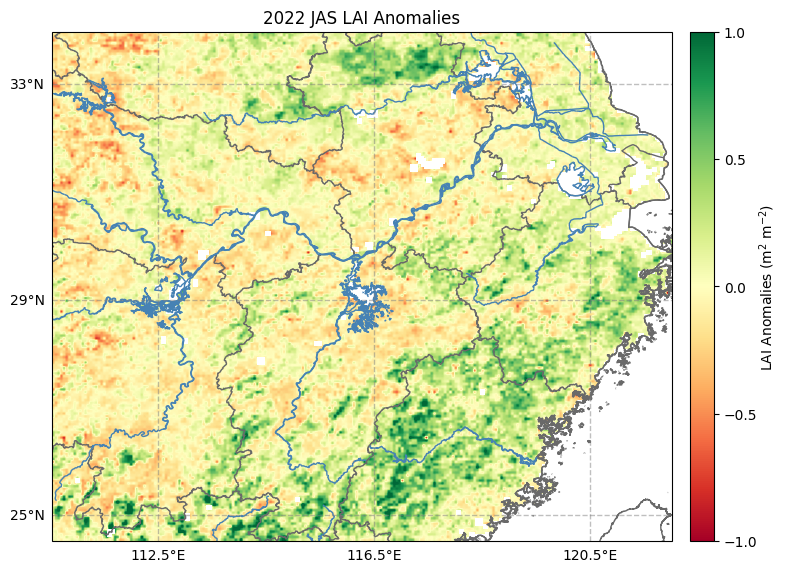

In [18]:
data = ds_ano789['vari'][20,:,:].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=1
vmin=-1
cmap = plt.get_cmap('RdYlGn')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('LAI Anomalies (m$^2$ m$^{-2}$)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 JAS LAI Anomalies')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 Jul. LAI Anomalies')

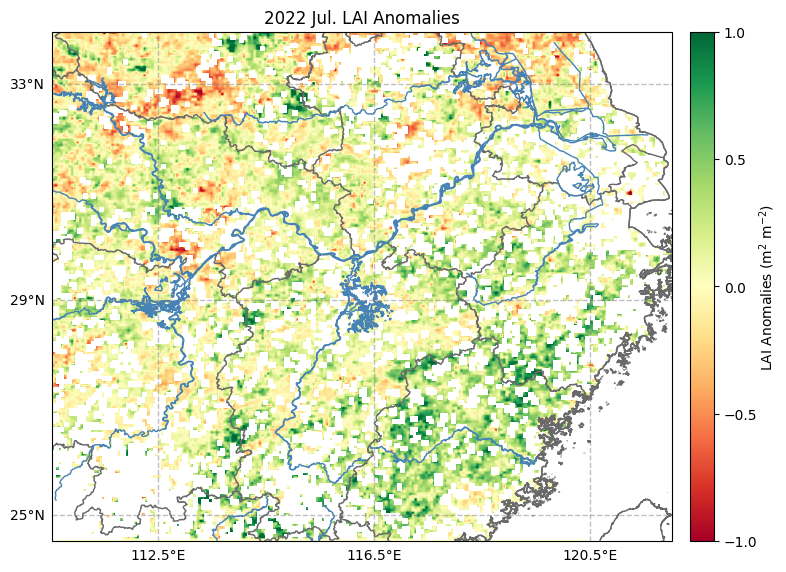

In [8]:
data = ds_ano7['vari'][20,:,:].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=1
vmin=-1
cmap = plt.get_cmap('RdYlGn')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('LAI Anomalies (m$^2$ m$^{-2}$)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 Jul. LAI Anomalies')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 Agu. LAI Anomalies')

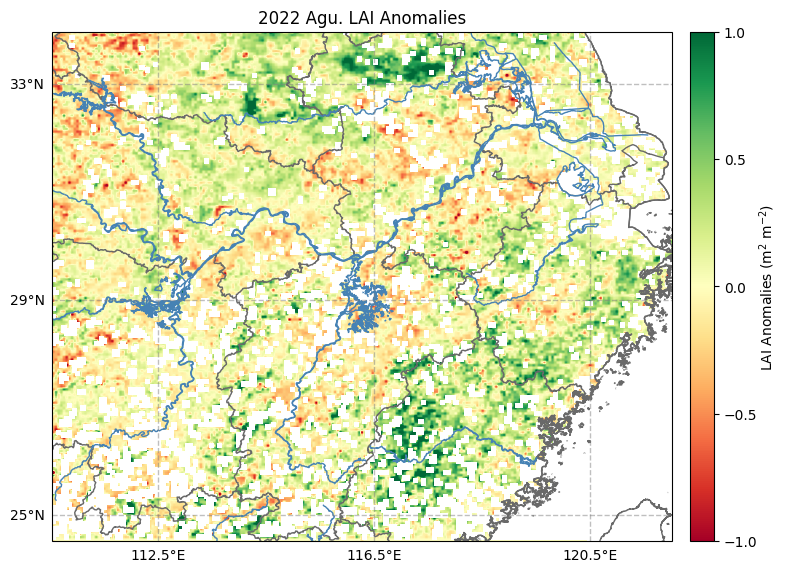

In [18]:
data = ds_ano8['vari'][20,:,:].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=1
vmin=-1
cmap = plt.get_cmap('RdYlGn')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('LAI Anomalies (m$^2$ m$^{-2}$)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 Agu. LAI Anomalies')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 Sep. LAI Anomalies')

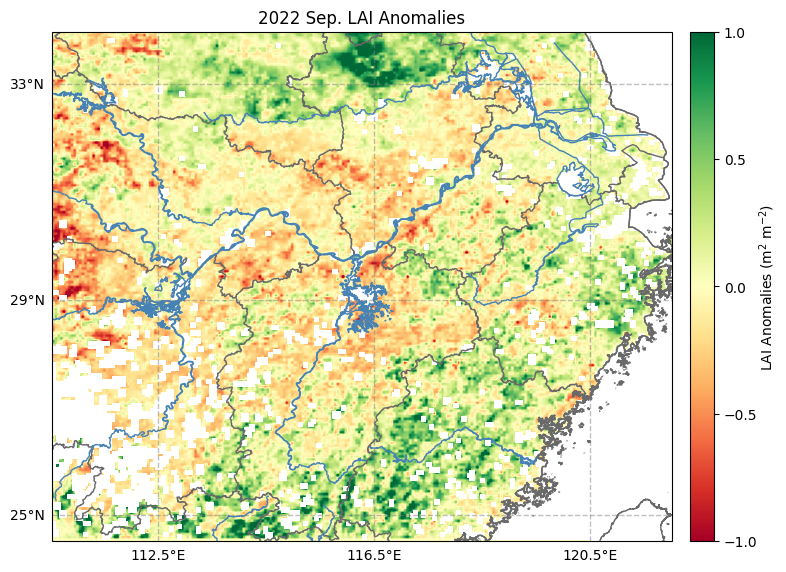

In [19]:
data = ds_ano9['vari'][20,:,:].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=1
vmin=-1
cmap = plt.get_cmap('RdYlGn')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('LAI Anomalies (m$^2$ m$^{-2}$)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 Sep. LAI Anomalies')